In [39]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [40]:
from scipy.constants import speed_of_light, elementary_charge, electron_mass, hbar

me_SI = electron_mass
hbar_SI = hbar   
e_SI = elementary_charge
c_SI = speed_of_light

meV = e_SI * 1e-3
nm = 1e-9
ps = 1e-12

c = c_SI * ps / nm           
hbar_meV_ps = hbar_SI / (meV * ps)  
me = me_SI * c_SI ** 2 / meV / c ** 2    

hbar = 1
m = 1
omega = 1

x_min = -np.pi
x_max = np.pi
t_min = 0
t_max = 2 * np.pi

In [41]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS backend for Apple GPU acceleration!")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using cuda")
else:
    device = torch.device("cpu")
    print("Using CPU instead.")

Using cuda


In [42]:
class PINN(nn.Module):
    def __init__(self, layers, t_min, t_max):
        super(PINN, self).__init__()
        self.hidden_layers = nn.ModuleList()
        
        for units in layers[1:-1]:
            self.hidden_layers.append(nn.Linear(in_features=layers[0], out_features=units))
            layers[0] = units
        
        self.output_layer = nn.Linear(layers[-2], layers[-1])

        self.n_collocation = 3000
        self.n_initial = 300
        self.n_boundary = 300

        self.t_min = t_min
        self.t_max = t_max
    
    def forward(self, inputs):
        x, t = inputs
        X = torch.stack((x, t), dim=1)
        activation_1 = nn.Tanh()
        activation_2 = nn.SiLU()
        i = 1
    
        for layer in self.hidden_layers:
            X = layer(X)
            X = activation_1(X) if i < 2 else activation_2(X)
            i += 1
    
        output = self.output_layer(X)
        psi_real = output[:, 0]
        psi_img = output[:, 1]
        
        return psi_real, psi_img

In [43]:
layers = [2, 512, 512, 512, 512, 512, 512, 2]

In [44]:
model = PINN(layers, t_min, t_max)

In [45]:
model.load_state_dict(torch.load("../results/baseline/model_1.pth", map_location=torch.device(device)))		

<All keys matched successfully>

In [46]:
import json

with open("../results/baseline/history_1.json", "r") as f:
  history = json.load(f)

epochs = 150000

In [47]:
total_loss_history = [record['total_loss'] for record in history]
physics_loss_history = [record['physics_loss'] for record in history]
initial_condition_loss_history = [record['initial_condition_loss'] for record in history]
boundary_condition_loss_history = [record['boundary_condition_loss'] for record in history]

epochs_range = range(1, epochs + 1)

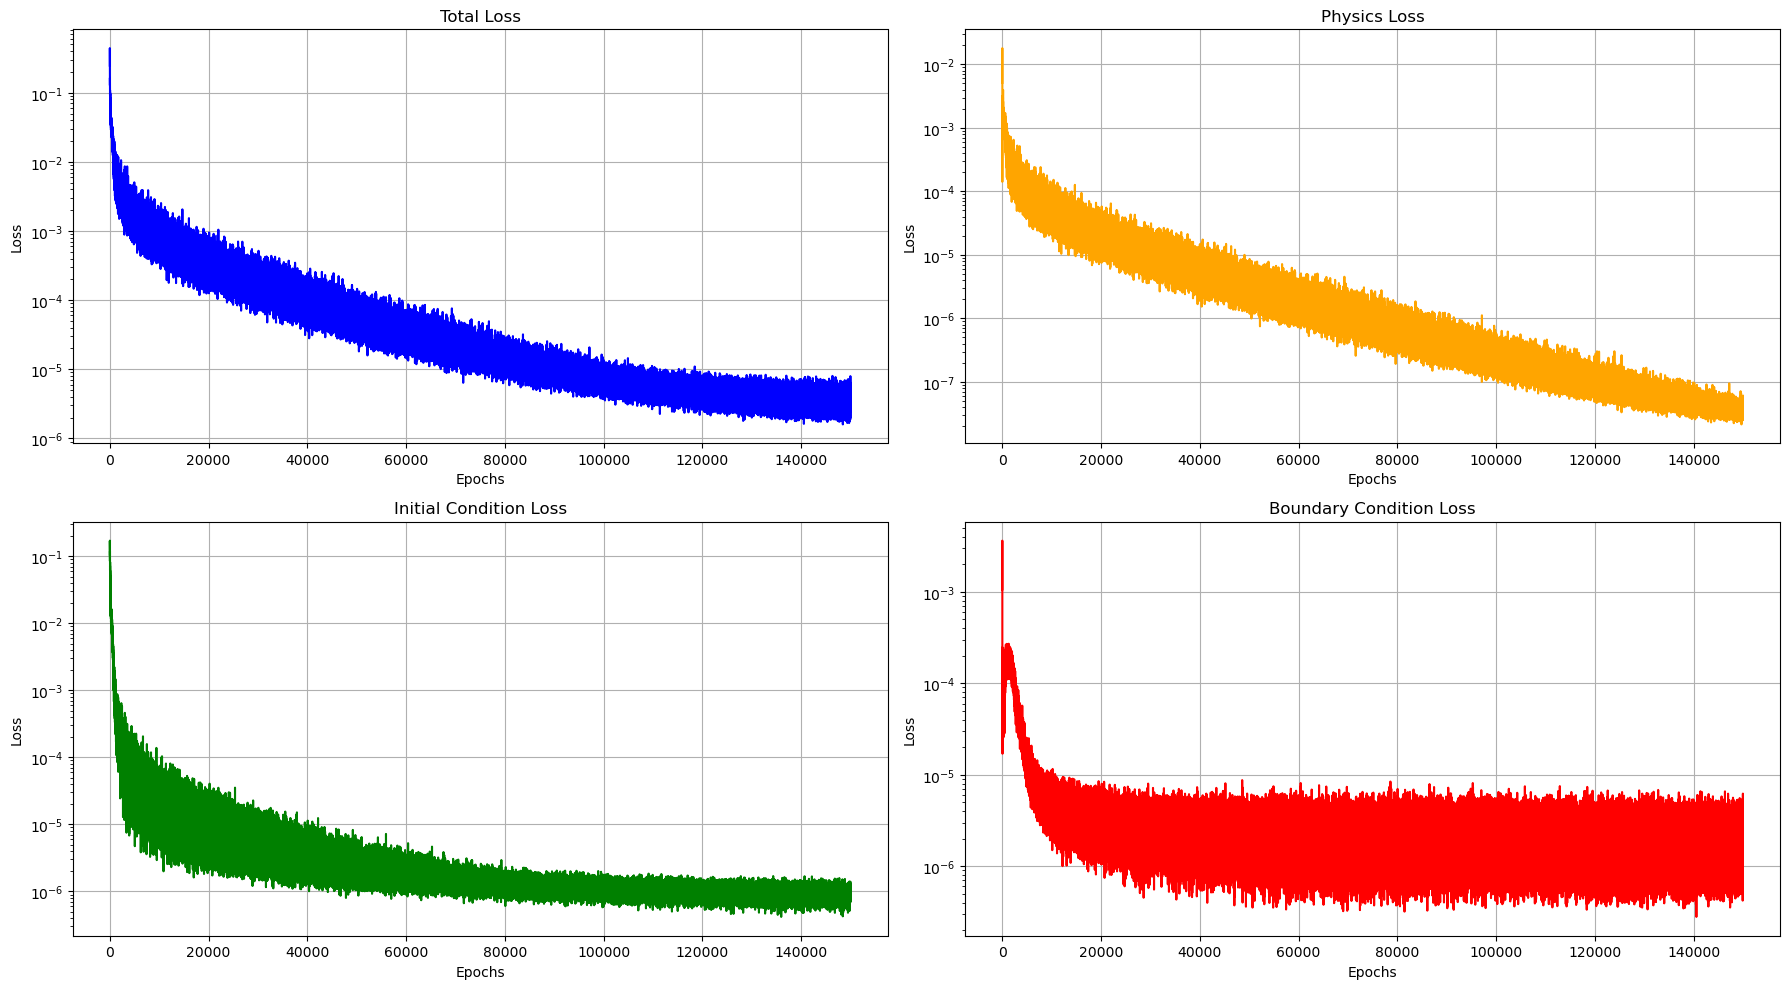

In [48]:
fig, axs = plt.subplots(2, 2, figsize=(18, 10))

# Total Loss
axs[0, 0].plot(epochs_range, total_loss_history, color='blue')
axs[0, 0].set_title('Total Loss')
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].grid(True)
axs[0, 0].set_yscale("log")

# Physics Loss
axs[0, 1].plot(epochs_range, physics_loss_history, color='orange')
axs[0, 1].set_title('Physics Loss')
axs[0, 1].set_xlabel('Epochs')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].grid(True)
axs[0, 1].set_yscale("log")

# Initial Condition Loss
axs[1, 0].plot(epochs_range, initial_condition_loss_history, color='green')
axs[1, 0].set_title('Initial Condition Loss')
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('Loss')
axs[1, 0].grid(True)
axs[1, 0].set_yscale("log")

# Boundary Condition Loss
axs[1, 1].plot(epochs_range, boundary_condition_loss_history, color='red')
axs[1, 1].set_title('Boundary Condition Loss')
axs[1, 1].set_xlabel('Epochs')
axs[1, 1].set_ylabel('Loss')
axs[1, 1].grid(True)
axs[1, 1].set_yscale("log")

plt.tight_layout()
plt.show()

In [49]:
def view_metrics(arr):
    mean = np.mean(arr)
    std = np.std(arr)
    mn = np.min(arr)
    mx = np.max(arr)
    
    fig = go.Figure(data=[go.Table(header=dict(values=['Mean', 'Standard Deviation', 'Min', 'Max']),
                 cells=dict(values=[[f"{mean:.5f}"], [f"{std:.5f}"], [f"{mn:.5f}"], [f"{mx:.5f}"]]))
                     ])
    fig.update_layout(width=500, height=300)
    fig.show()

In [50]:
Nx = 2000
Nt = 2000

x_values = np.linspace(x_min, x_max, Nx)
t_values = np.linspace(t_min, t_max, Nt)

In [51]:
def analytical(x, t):
    A = (1 / np.sqrt(2)) * ((1 / np.pi) ** 0.25) * np.exp(-(x ** 2) / 2)
    B1 = np.exp(-1j * 0.5 * t)
    B2 = np.exp(-1j * 1.5 * t) * np.sqrt(2) * x
    return A * (B1 + B2)

In [52]:
psi_real_analytical = np.zeros((Nx, Nt), dtype=np.float64)
psi_img_analytical = np.zeros((Nx, Nt), dtype=np.float64)

for i, x in enumerate(x_values):
    for j, t in enumerate(t_values):
        psi_x_t = analytical(x, t)

        psi_real_analytical[i, j] = np.real(psi_x_t)
        psi_img_analytical[i, j] = np.imag(psi_x_t)

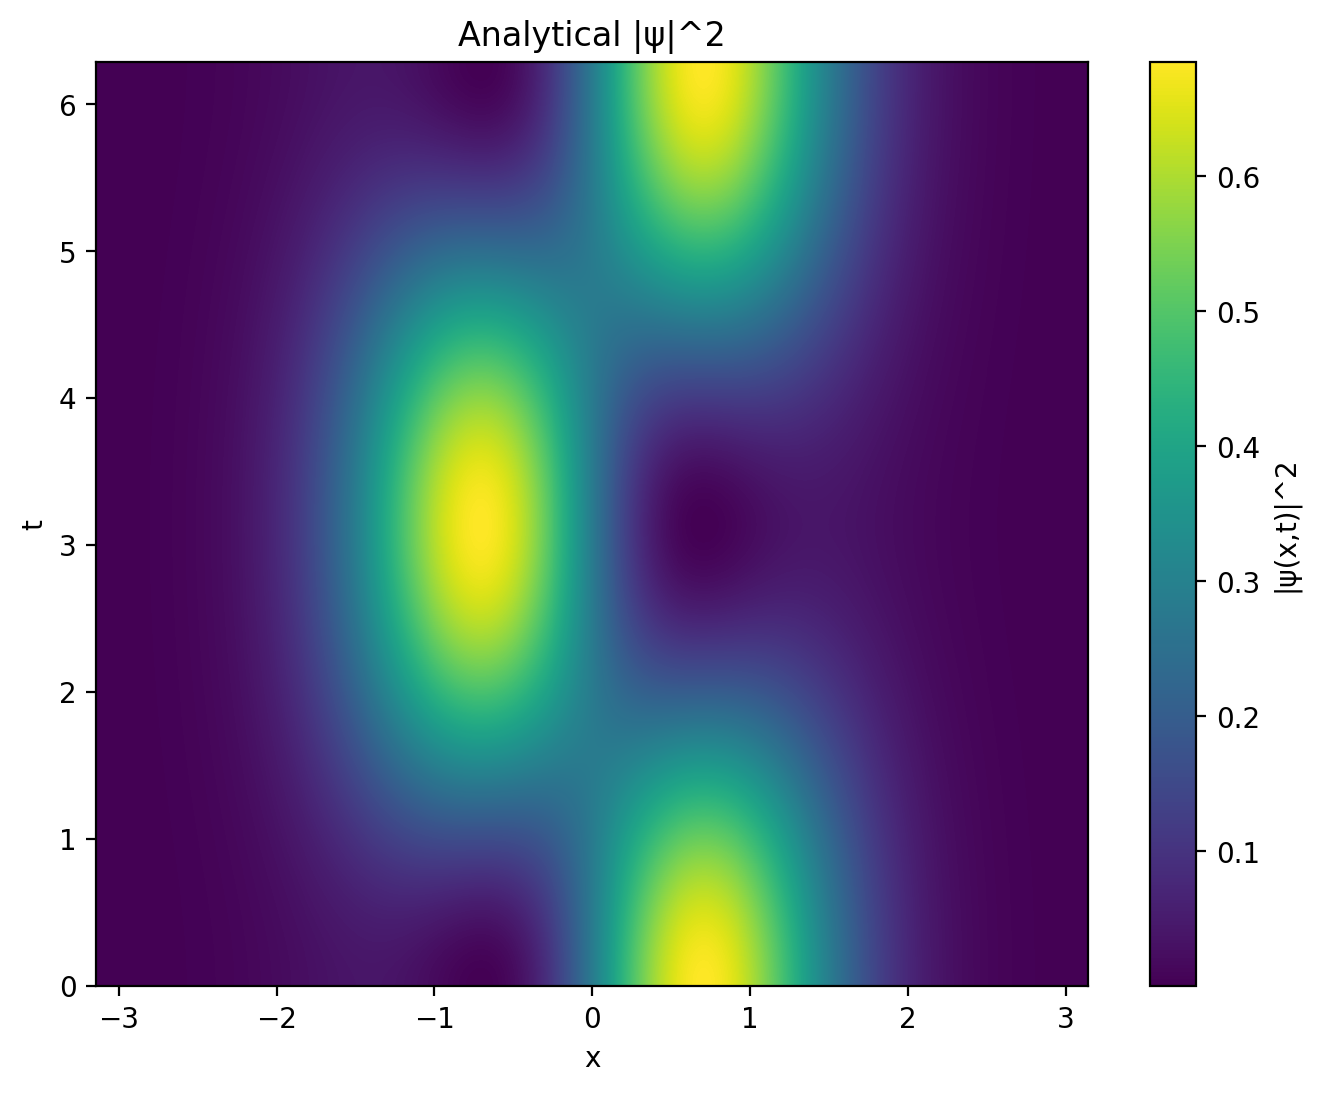

In [53]:
plt.figure(figsize=(8, 6), dpi=200)
psi_sq_analytical = psi_real_analytical ** 2 + psi_img_analytical ** 2

plt.pcolormesh(x_values, t_values, psi_sq_analytical.transpose(), shading="auto")
plt.colorbar(label='|ψ(x,t)|^2')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Analytical |ψ|^2')
plt.show()

In [54]:
x_values_torch = torch.from_numpy(x_values).float()
t_values_torch = torch.from_numpy(t_values).float()

x_grid, t_grid = torch.meshgrid(x_values_torch, t_values_torch, indexing="ij")

x_flat = torch.reshape(x_grid, [-1])
t_flat = torch.reshape(t_grid, [-1])

batch_size = 1000000
psi_real_list = []
psi_img_list = []

model.eval()
with torch.no_grad():
    for i in range(0, x_flat.shape[0], batch_size):
        x_batch = x_flat[i:i+batch_size]
        t_batch = t_flat[i:i+batch_size]
        psi_real, psi_img = model((x_batch, t_batch))
        psi_real_list.append(psi_real.cpu())
        psi_img_list.append(psi_img.cpu())

# psi_real_pinn, psi_img_pinn = model((x_flat, t_flat))

# psi_real_pinn = torch.reshape(psi_real_pinn, (Nx, Nt))
# psi_img_pinn = torch.reshape(psi_img_pinn, (Nx, Nt))

psi_real_pinn = torch.cat(psi_real_list).reshape(Nx, Nt).numpy()
psi_img_pinn = torch.cat(psi_img_list).reshape(Nx, Nt).numpy()

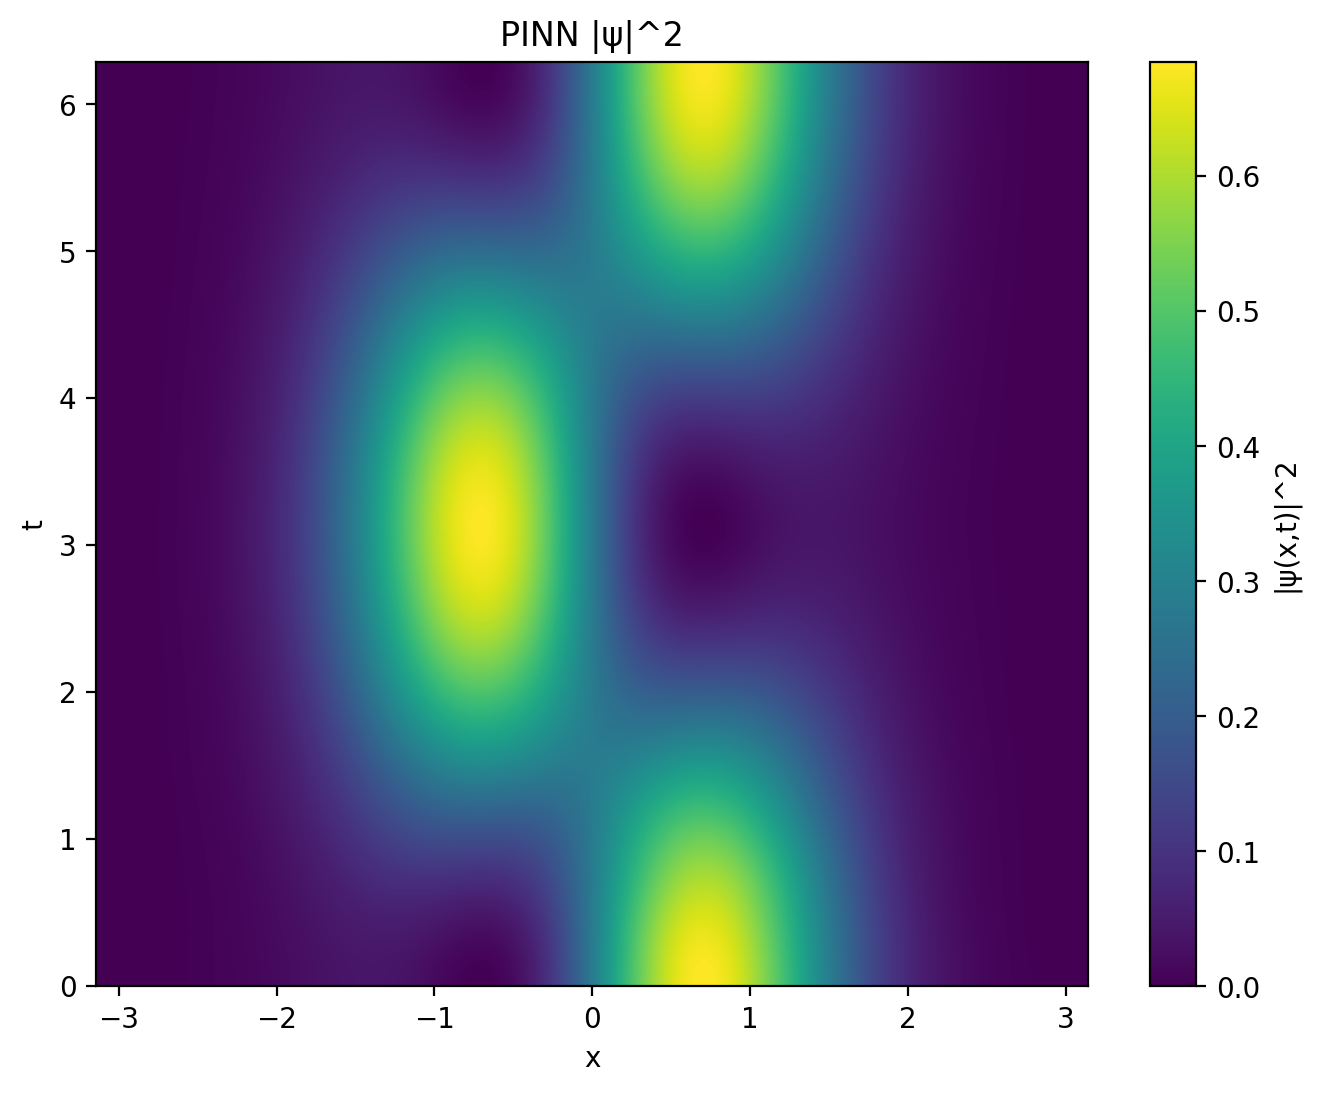

In [55]:
plt.figure(figsize=(8, 6), dpi=200)
psi_sq_pinn = psi_real_pinn ** 2 + psi_img_pinn ** 2

plt.pcolormesh(x_values, t_values, psi_sq_pinn.transpose(), shading="auto")
plt.colorbar(label='|ψ(x,t)|^2')	
plt.xlabel('x')
plt.ylabel('t')
plt.title('PINN |ψ|^2')
plt.show()

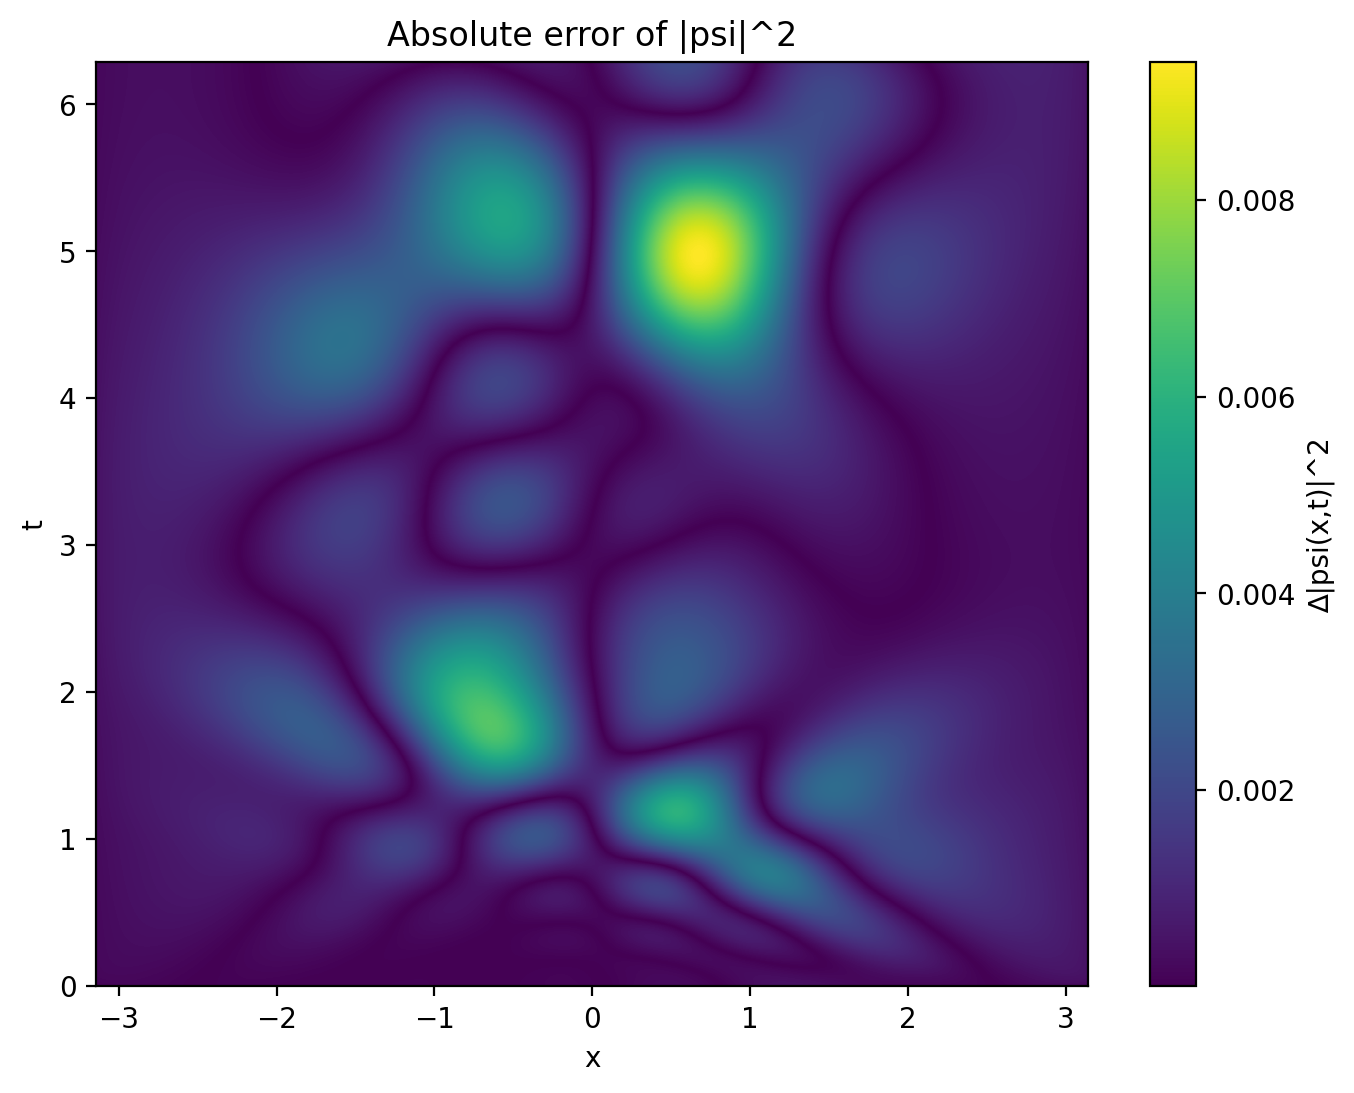

In [ ]:
plt.figure(figsize=(8, 6), dpi=200)
psi_sq_diff = np.abs(psi_sq_pinn - psi_sq_analytical)
view_metrics(psi_sq_diff)

plt.pcolormesh(x_values, t_values, psi_sq_diff.transpose(), shading="auto")
plt.colorbar(label='∆|psi(x,t)|^2')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Absolute error of |psi|^2')
plt.show()

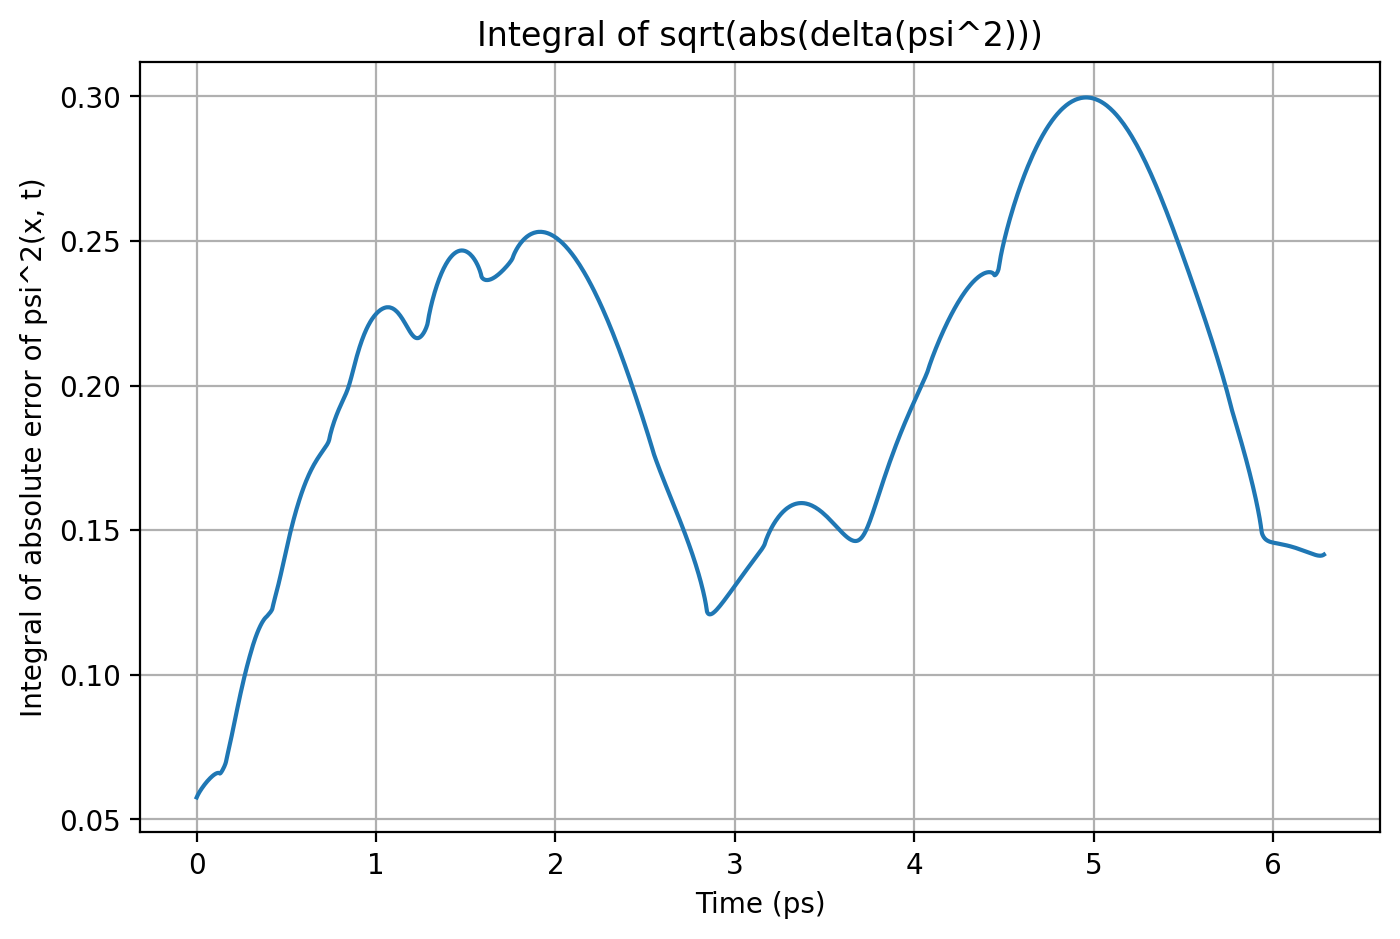

In [57]:
diff_integrals = np.sqrt(psi_sq_diff).mean(axis=0) * (x_max - x_min)
view_metrics(diff_integrals)

plt.figure(figsize=(8,5), dpi=200)
plt.plot(t_values, diff_integrals, '-')
plt.xlabel('Time (ps)')
plt.ylabel('Integral of absolute error of psi^2(x, t)')
plt.title('Integral of sqrt(abs(delta(psi^2)))')
plt.grid(True)
plt.show()

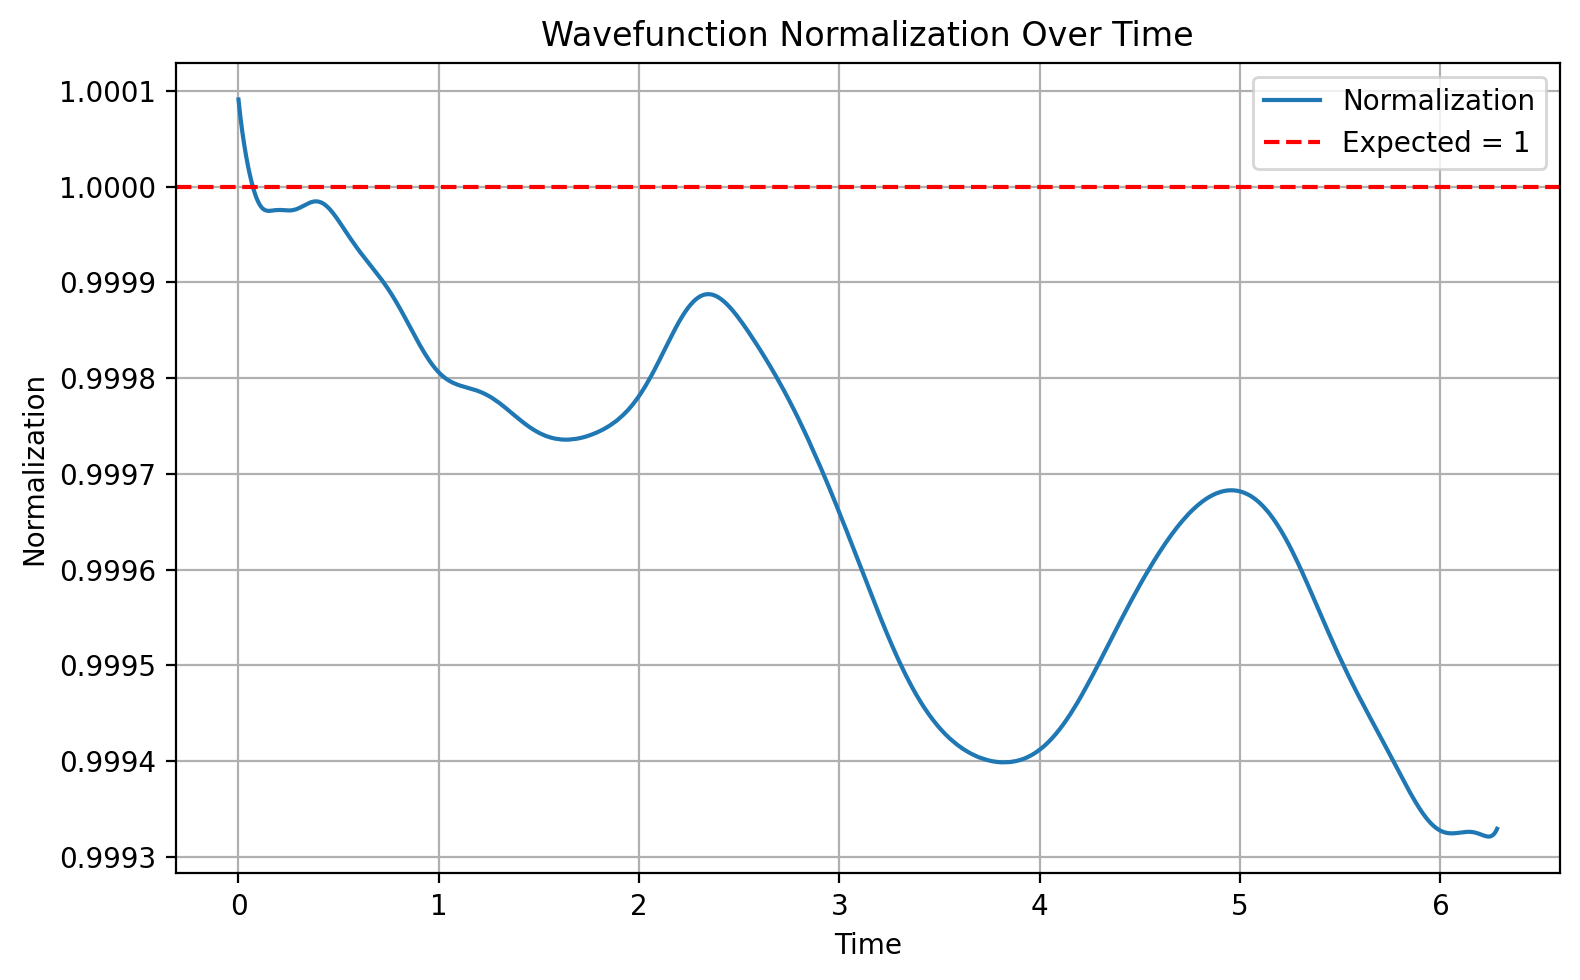

In [58]:
from scipy.integrate import simpson

norms = []

for i in range(2000):
    psi_sq_i = psi_real_pinn[:, i] ** 2 + psi_img_pinn[:, i] ** 2
    normalization = simpson(psi_sq_i, x=x_values)
    normalization_monte = np.mean(psi_sq_i) * (x_max - x_min)
    norms.append(normalization)
    
view_metrics(np.array(norms))

fig, ax = plt.subplots(figsize=(8, 5), dpi=200)

ax.plot(t_values, norms, '-', label='Normalization')
ax.axhline(1.0, color='red', linestyle='--', label='Expected = 1')

ax.yaxis.get_major_formatter().set_useOffset(False)

ax.set_xlabel('Time')
ax.set_ylabel('Normalization')
ax.set_title('Wavefunction Normalization Over Time')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()